In [1]:
import numpy as npy
import pandas as pd 
import pandas_datareader as pdr 
import yfinance as yf
import matplotlib.pyplot as plt 
from matplotlib import rcParams 
rcParams ['figure.figsize'] = 8,6 
import seaborn as sb 
sb.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [2]:
yf.pdr_override()
from pandas_datareader import data as dt 
amzn = pdr.data.get_data_yahoo('AMZN')
# amzn = dt.get_data_yahoo('AMZN')

[*********************100%***********************]  1 of 1 completed


In [3]:
amzn.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000


In [4]:
amzn_close = amzn['Close']
amzn_return = round(npy.log(amzn_close).diff()*100,2)
amzn_return.head()

Date
1997-05-15      NaN
1997-05-16   -12.45
1997-05-19    -1.21
1997-05-20    -4.36
1997-05-21   -13.63
Name: Close, dtype: float64

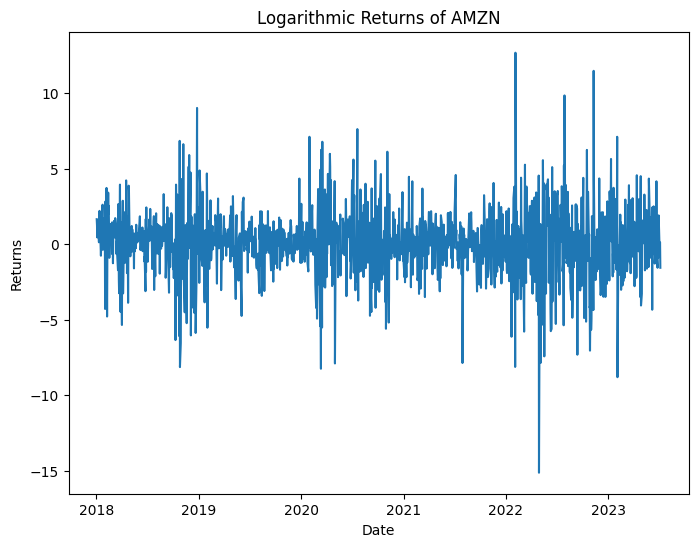

In [5]:
start_date = '2018'
end_date = '2023'

return_ranged = amzn_return[start_date:end_date]

plt.plot(return_ranged)
plt.title('Logarithmic Returns of AMZN')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()


In [6]:
#basic descriptive statistics
return_ranged.dropna(inplace = True)
return_ranged.describe()

count    1386.000000
mean        0.056760
std         2.252848
min       -15.140000
25%        -1.067500
50%         0.125000
75%         1.217500
max        12.690000
Name: Close, dtype: float64

In [8]:
from scipy import stats 
result = stats.describe(return_ranged)

print("Count:", result.nobs)
print("Mean:", result.mean)
print("Variance:", result.variance)
print("Minimum:", result.minmax[0])
print("Maximum:", result.minmax[1])
print("Skewness:", result.skewness)
print("Kurtosis:", result.kurtosis)

Count: 1386
Mean: 0.056760461760461775
Variance: 5.075326176515022
Minimum: -15.14
Maximum: 12.69
Skewness: -0.1707400076178328
Kurtosis: 3.930548773978053


NORMALITY AND TESTS


In [9]:
n, minmax, mean, var, skew, kurt = stats.describe(return_ranged)
mini, maxi = minmax
std = var ** .5

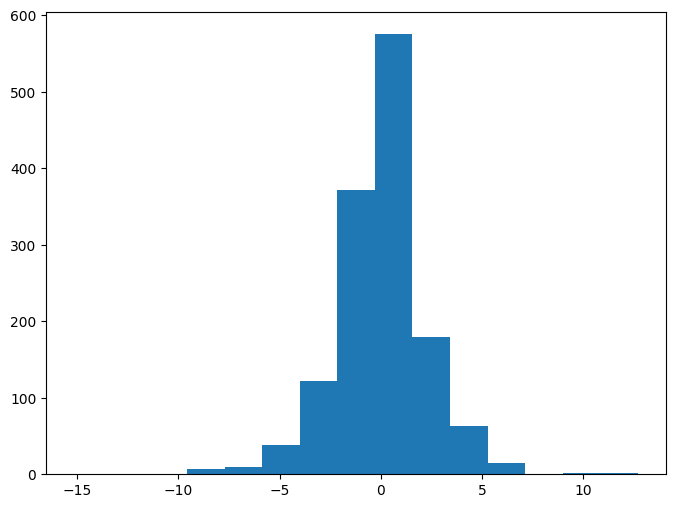

In [10]:
plt.hist(return_ranged, bins=15);

In [11]:
from scipy.stats import norm
x = norm.rvs(mean, std, n)

(array([  4.,  15.,  20.,  51.,  99., 165., 240., 270., 209., 144.,  97.,
         49.,  14.,   7.,   2.]),
 array([-7.58385356, -6.55245432, -5.52105507, -4.48965583, -3.45825659,
        -2.42685734, -1.3954581 , -0.36405885,  0.66734039,  1.69873964,
         2.73013888,  3.76153812,  4.79293737,  5.82433661,  6.85573586,
         7.8871351 ]),
 <BarContainer object of 15 artists>)

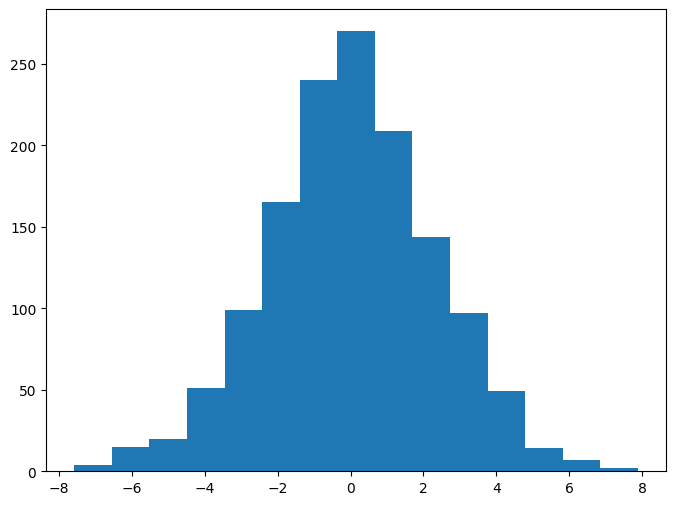

In [12]:
plt.hist(x,bins=15)

In [170]:
#STATISTICAL TESTS
x_test = stats.kurtosistest(x)
amzn_test = stats.kurtosistest(amzn_return)

print(f'{"           t-statistic":20}{"p-value ":>15}')
print(f'{"  "*5}{"-"* 30}')
print(f"x:{x_test[ 0]:>17.2f}{x_test[1]:16.3f}")
print(f"AMZN: {amzn_test[0]:13.2f}{amzn_test[1]:16.4f}")

#amzn is giving nan values

           t-statistic       p-value 
          ------------------------------
x:             1.27           0.205
AMZN:           nan             nan


In [169]:


# extracting on nan values from amzn returns using numpy (npy)

x_test = stats.kurtosistest(x)
amzn_return_without_nan = amzn_return[~npy.isnan(amzn_return)]
amzn_test = stats.kurtosistest(amzn_return_without_nan)

print(f'{"           t-statistic":20}{"p-value ":>15}')
print(f'{"  "*5}{"-"*30}')
print(f"x:    {x_test[0]:>14.2f}{x_test[1]:16.3f}")
if npy.isnan(amzn_test[0]) or npy.isnan(amzn_test[1]):
    print("AMZN: Test not applicable due to missing values or constant data")
else:
    print(f"AMZN: {amzn_test[0]:>14.2f}{amzn_test[1]:16.4f}")


           t-statistic       p-value 
          ------------------------------
x:              1.27           0.205
AMZN:          33.18          0.0000


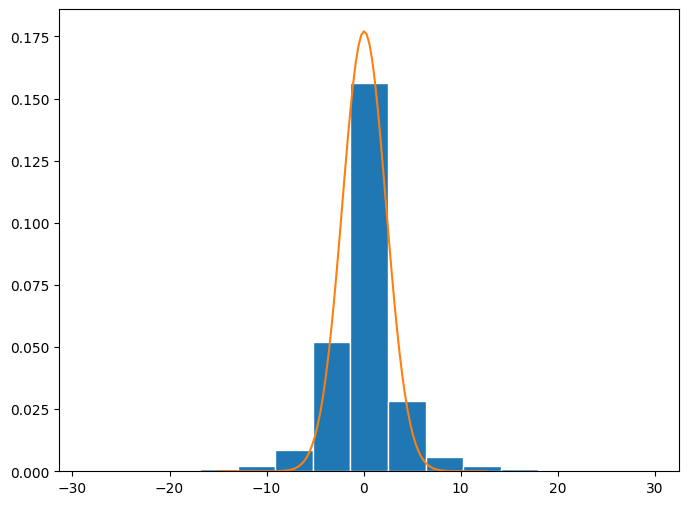

In [17]:
plt.hist(amzn_return, bins=15, edgecolor= 'w', density=True)
overlay =  npy.linspace(mini, maxi, 100)
plt.plot(overlay, norm.pdf(overlay, mean, std));

In [18]:
#T TEST
stats.ttest_1samp(amzn_return.sample(252),0, alternative='two-sided')

TtestResult(statistic=0.13570409057599642, pvalue=0.8921639828588817, df=251)

CAN THE PRICE MOVEMENT BE DESCRIBED AS A RANDOM WALK ?


1. Creating price lags

In [159]:
amzn_close = pd.DataFrame(amzn_close, columns=['Close'])
amzn_close['lag_1'] = amzn_close.Close.shift(1)
amzn_close['lag_2'] = amzn_close.Close.shift(2)
amzn_close.dropna(inplace=True)
amzn_close.head(5)

,Close,lag_1,lag_2
Date,,,
1998-06-29,0.822917,0.785417,0.825521
1998-06-30,0.831250,0.822917,0.785417
1998-07-01,0.951042,0.831250,0.822917
1998-07-02,1.033333,0.951042,0.831250
1998-07-06,1.162500,1.033333,0.951042


2. Creating a predictive regression model


In [182]:
#linear algebra and least squares model
lr = npy.linalg.lstsq(amzn_close[['lag_1','lag_2']],amzn_close['Close'], rcond= None)[0]
lr
#will give slope coefficients for lag_1 and lag_2
#lag_1's coefficient, say A1 means A1 % of tomorrow's price can be predicted using today's price. A2 = 100-A1

array([0.97415682, 0.02599344])

3. Fitting this in the actual data

In [195]:
amzn_close['predicted values'] = npy.dot(amzn_close[['lag_1','lag_2']],lr)

In [205]:
amzn_close.head()



,Close,lag_1,lag_2,predicted values,predicted values
Date,,,,,
1998-06-29,0.822917,0.785417,0.825521,0.786577,0.786577
1998-06-30,0.831250,0.822917,0.785417,0.822066,0.822066
1998-07-01,0.951042,0.831250,0.822917,0.831158,0.831158
1998-07-02,1.033333,0.951042,0.831250,0.948071,0.948071
1998-07-06,1.162500,1.033333,0.951042,1.031349,1.031349


4. Visualizing actual closing price vs predicted closing price

<AxesSubplot: xlabel='Date'>

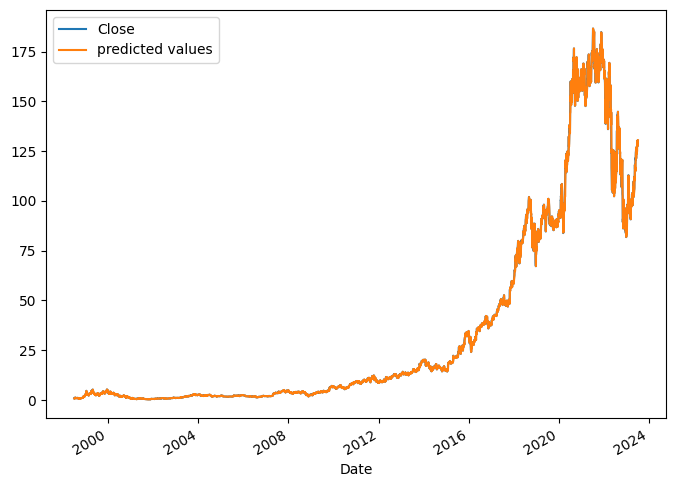

In [206]:

amzn_close[['Close','predicted values']].plot()

5. Visualizing how well today's price is forecasting tomorrow's price

<AxesSubplot: xlabel='Date'>

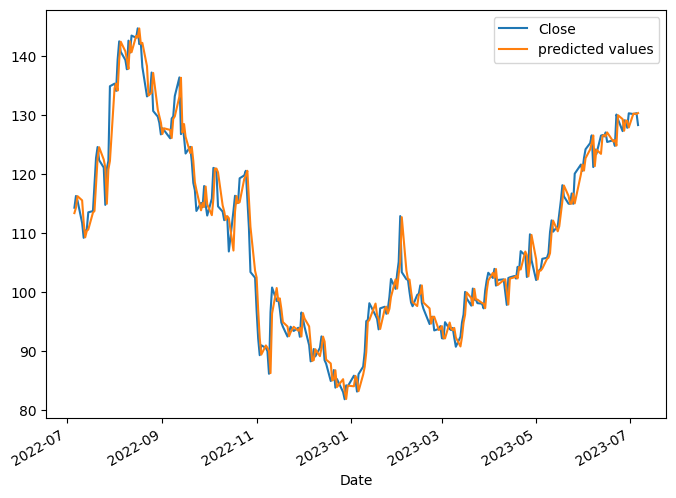

In [208]:
amzn_close.iloc[-252:][['Close','predicted values']].plot()